# Assignment 2: Lane Detection

In this assignment you will implement a lane detection algorithm and fine tune the parameters for 2 images. You are allowed to use Numpy and OpenCV library for your implemetation. We also provide a helper funcion, `line_spacing`, that you are allowed to use in your solution.

First, we import for you the necessary libraries and allow plotting of figures (disabled when using autograder).

In [2]:
#Don't touch these
import cv2
import numpy as np
import matplotlib.pyplot as plt

plotting = False
if __name__ == '__main__':    
    plotting = True

In the next code cell, we read the first road image, `road1.png`, file and display it. For the lane detection, we do not really require the colors, so we directly read the image as a grayscale image (just one color channel).

The image size is: (768, 1024)


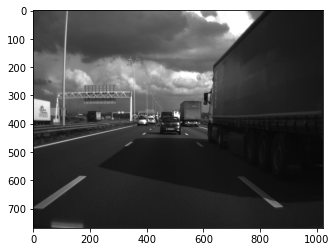

In [5]:
img_road_num = '1'
img_road = cv2.imread('road' + img_road_num + '.png', cv2.IMREAD_GRAYSCALE)

if plotting: 
    plt.imshow(img_road, cmap='gray')
    # By printing the image shape we can see its dimensions. Since, it is a grayscale image, we only get the size of the image resolution. 
    print("The image size is: " + str(img_road.shape))

We can also read the collored image as shown below 

The image size is: (768, 1024, 3)


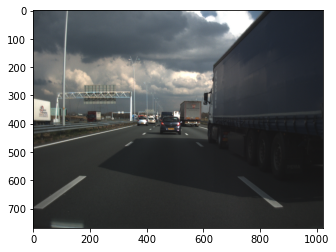

In [6]:
img_road_color = cv2.imread('road' + img_road_num + '.png', cv2.IMREAD_COLOR)
img_road_rgb = cv2.cvtColor(img_road_color, cv2.COLOR_BGR2RGB) # by default OpenCV read the image as BGR and not RGB (legacy reasons), so we need to change the order of color channels 

if plotting: 
    plt.imshow(img_road_rgb)
    # By printing the image shape we can see its dimensions. Since, it is a color image, we now get the size of the image resolution x the color channels. 
    print("The image size is: " + str(img_road_color.shape))

We usually do not need the entire image to find the lines. Hence, we can crop the upper part of image, which is above the horizon. The follwoing code demonstrate this for the first road image, we have just read.

The image size is: (383, 1024)


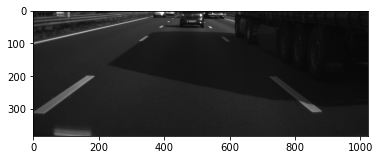

In [7]:
crop_size = 385
img_road_crop = img_road[0:1023][crop_size:]

if plotting: 
    plt.imshow(img_road_crop, cmap='gray')
    print("The image size is: " + str(img_road_crop.shape))

The lane detection algorithm has multiple processing steps. Each step has its own parameters that need to be fine-tuned. You are expected to use OpenCV library in each function to implement the required functionality.
Hence, please use any OpenCV tutorial or official documentation to find the appropriate function to be used, e.g.:
* [OpenCV Tutorial - GeeksForGeeks](https://www.geeksforgeeks.org/opencv-python-tutorial/)
* [OpenCV Tutorial - OpenCV ](https://docs.opencv.org/master/d6/d00/tutorial_py_root.html)
* [OpenCV Docs](https://docs.opencv.org/master/)

## Exercise 1a: Laplacian over Gaussian filter

Usually, the fist step in an image processing is to apply an image filter to the image.   

Implement and apply on the input image the Laplacian over Gaussian filter in `LoG` function. Choose (Fine-tune) some meaningfull parameter values for blocksize and sigma to test and display your results.

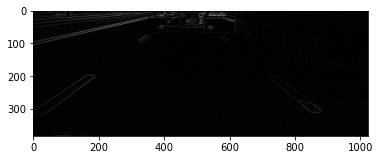

In [8]:
def LoG(image, blocksize, sigma):
    #Add your code here
    gau = cv2.GaussianBlur(image,(blocksize,blocksize),sigma)
    filt_road = cv2.Laplacian(gau,cv2.CV_8U,ksize=blocksize)
    return filt_road

if plotting:
    # Change (Fine-tune) the parameter values. 
    blocksize = 3
    sigma_log = 0.55

    # We call the function and then we plot the results
    filt_road = LoG(img_road_crop, blocksize, sigma_log)
#     cv2.imshow('1', filt_road)
  
#     #waits for user to press any key 
#     #(this is necessary to avoid Python kernel form crashing)
#     cv2.waitKey(0) 

#     #closing all open windows 
#     cv2.destroyAllWindows() 
    
    plt.imshow(filt_road, cmap='gray')

## Exercise 1b: Adaptive thresholding

After filtering, we want to apply adaptive thresholding. Implement thresholding the image to 0 or 255 in `thresholding` function and apply to the road image which was filterred with LoG. Fine-tune the parameters. 

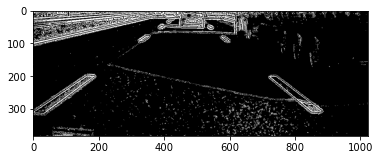

In [9]:
def thresholding(image, neighborhood_threshold, constant_threshold):
    #Add your code here
    threshold_road = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,neighborhood_threshold,constant_threshold) 
    return threshold_road

if plotting:
    # Fine-tune the parameters
    neighborhood_threshold = 9 
    constant_threshold = 4.5
    
    thresh_road = thresholding(filt_road, neighborhood_threshold, constant_threshold)
    plt.imshow(thresh_road, cmap='gray')
#     cv2.imshow('2', thresh_road)
  
#     #waits for user to press any key 
#     #(this is necessary to avoid Python kernel form crashing)
#     cv2.waitKey(0) 

#     #closing all open windows 
#     cv2.destroyAllWindows() 
#     #thresholding_csv = np.loadtxt('Thresholding.csv',delimiter=",",dtype = np.uint8)
#     plt.imshow(thresholding_csv, cmap='gray')

## Exercise 1c: Morphological operation

Remove the noise from the thresholded edge image using morphological opening. 

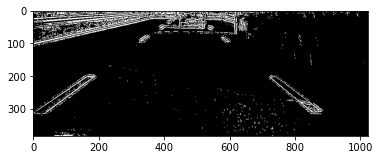

In [10]:
def morph_open(image, kernel):
    #Add your code here
    morph_opened = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
    return morph_opened

if plotting:
    # Choose the appropriate kernel values
    kernel = np.array([[1, 1, 0],[0, 1, 0],[0, 0, 0]], np.uint8)
    
    morph_opened = morph_open(thresh_road, kernel)

    plt.imshow(morph_opened, cmap='gray')
    
#     morph_test_correct = np.loadtxt('Morphological_opening.csv',delimiter=",",dtype = np.uint8)
#     plt.imshow(morph_test_correct, cmap='gray')

## Exercise 2a: The hough transform

In the second part of the assignment, you will implement hough transform to detect the hough lines and do the postprocessing to get the final lines.
Before, however, we define a helper function that adds lines into an image, so we can visually plot them.

In [11]:
# Do not touch this code. It contains helper functions for adding lines into an image
def insert_hough_lines(hough_lines, image, crop_size):
    for x in range(0, len(hough_lines)):
        for x1,y1,x2,y2 in hough_lines[x]:
            cv2.line(image, (x1,y1+crop_size), (x2,y2+crop_size), (0,255,0), 2)

def insert_lines(lines, image, crop_size):
    """ 
    This function takes an input image and add lines into it
    crop_size: it is the upper part of the image where the lines are applied  (where we crop the image before finding the lines)
    """
    for line in lines:
        cv2.line(image, (line[0],line[1]+crop_size), (line[2],line[3]+crop_size), (0,255,0), 1)

Now, in the cell below, create lines using the hough transform using OpenCV library.

For plotting, we then add the created lines into the image and then we plot it. Notice, we plot the lines over the collored image.

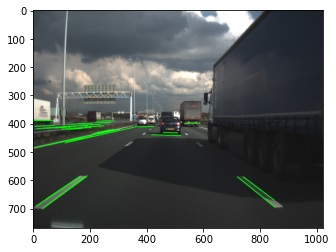

In [12]:
def hough_lines(image, threshold_hough, min_length, max_gap):
    #Add your code here
    lines = cv2.HoughLinesP(image,rho=1,theta=np.pi/180,threshold=threshold_hough,minLineLength=min_length,maxLineGap=max_gap)
#     lines = cv2.HoughLinesP(image,1,np.pi/180,threshold_hough,min_length,max_gap)
    return lines

if plotting:
    # Fine-tune the parameters
    threshold_hough = 100
    min_length = 50
    max_gap = 1
    
    lines = hough_lines(morph_opened, threshold_hough, min_length, max_gap)
    img_road_rgb = cv2.cvtColor(img_road_color, cv2.COLOR_BGR2RGB) # we re-initialize the rgb image, to overwrite any previously inserted lines
#     insert_lines(np.loadtxt('Hough_lines.csv',delimiter=",",dtype = np.int32), img_road_rgb, crop_size)
    insert_hough_lines(lines, img_road_rgb, crop_size)
    plt.imshow(img_road_rgb)

## Exercise 2b: Post-process the lines

Very likely we see we get too many lines. We need to filter some of them. The criteria for filtering are:
* Preserve only lines that are spaced from each other above a given margin (use the helper function `line_spacing` provided below)
* Preserve only the lines which have the steepnes (|slope|) above a given steepnes threshold  

First execute the cell below the define the helper function.

In [13]:
# Do not touch this code. It contains the helper function for filtering densely spaced lines 
def line_spacing(lines, margin):
    a = np.zeros(len(lines))
    b = np.zeros(len(lines))

    check = np.zeros(len(lines))
    for j in range(len(lines)):
        x1,y1,x2,y2 = lines[j][0]
        a[j] = (y2-y1)/(x2-x1); #ax+b
        check[j] = 1
        for k in range(len(lines)):
            if (k < j and 
                ((a[k] <= a[j]*margin and a[k] >= a[j]/margin and a[j] > 0) or (a[k] >= a[j]*margin and a[k] <= a[j]/margin and a[j] <= 0))):
                check[j] = 0;  #0<margin<1 
    return lines[np.nonzero(check)]

Implement the filter_line function that satisfy the filter criteria defined above. This is the only function, where you do not use OpenCV library, but you can use the helper function we just defined.

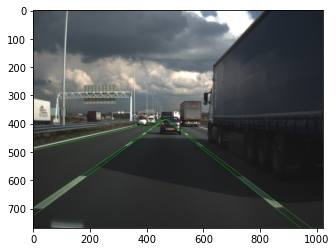

In [14]:
def filter_lines(lines, margin, steepness, image):
    #Add your code here
    filtered_lines = line_spacing(lines,margin)
#     print(filtered_lines)
    a = np.zeros(len(filtered_lines))
    im_height = image.shape[0]
    check = np.zeros(len(filtered_lines))
    for j in range(len(filtered_lines)):
        x1,y1,x2,y2 = filtered_lines[j][0]
        a[j] = (y2-y1)/(x2-x1)
        check[j] = 0
        if np.absolute(a[j])>= np.absolute(steepness):
            check[j] = 1
    fl = filtered_lines[np.nonzero(check)][:,0,:]
    for j in range(len(fl)):
        slope = (fl[j][3]-fl[j][1])/(fl[j][2]-fl[j][0])
        interc = fl[j][1]-fl[j][0]*slope
        fl[j][3] = im_height
        fl[j][1] = 0
        fl[j][2] = (im_height-interc)//slope
        fl[j][0] = (0-interc)//slope
    return fl

if plotting:
    # Fine-tune the parameters
    steepness  = 0.225
    margin = 1.05

#     filtered_lines = filter_lines( np.expand_dims(np.loadtxt('Hough_lines.csv',delimiter=",",dtype = np.int32), axis=1), margin, steepness, img_road_crop)
    filtered_lines = filter_lines(lines, margin, steepness, img_road_crop)
    img_road_rgb = cv2.cvtColor(img_road_color, cv2.COLOR_BGR2RGB) # we re-initialize the rgb image, to overwrite the previously inserted hough lines
    insert_lines(filtered_lines, img_road_rgb, crop_size)

#     cv2.imshow('1', img_road_rgb)
#     #(this is necessary to avoid Python kernel form crashing)
#     cv2.waitKey(0) 
#     #closing all open windows 
#     cv2.destroyAllWindows() 

    plt.imshow(img_road_rgb)

## Exercise 2c: Implement the entire pipeline

Now, you are supposed to put the entire pipeline together and fine-tune the parameters for the two road images: `road1.png` and `road2.png`

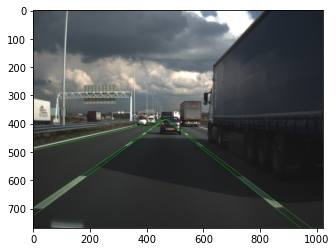

In [15]:
def Lane_detection(img_road_num, plotting):
    if (img_road_num == '1'):
        # Define the parameters for road1.png image
        blocksize = 3
        steepness = 0.225
        kernel = np.array([[1, 1, 0],[0, 1, 0],[0, 0, 0]], np.uint8)
        margin = 1.05
        sigma_log = 0.55
        neighborhood_threshold = 9
        constant_threshold = 4.5
        threshold_hough = 100
        min_length = 50
        max_gap = 1

        # We define the crop_size for you
        crop_size = 385
    else:  
        # Define the parameters for road2.png image
        blocksize = 1
        steepness = 0.305
        kernel = np.array([[0, 1,1],[1,1, 1],[1,0, 1]], np.uint8)
        margin = 1.19
        sigma_log = 0.15
        neighborhood_threshold = 35
        constant_threshold = 4.5
        threshold_hough = 50
        min_length = 11
        max_gap = 1
        
        # We define the crop_size for you
        crop_size = 440
    
    # We read the image for you
    img_rgb = cv2.cvtColor(
        cv2.imread('road' + img_road_num + '.png', cv2.IMREAD_COLOR), 
        cv2.COLOR_BGR2RGB)

    img_gray = cv2.imread('road' + img_road_num + '.png', cv2.IMREAD_GRAYSCALE)
        
    #Add your code here (do not forget to crop the image and insert lines to the rgb image for plotting the result)
    img_road_crop = img_gray[:][crop_size:]
    filt_road = LoG(img_road_crop, blocksize, sigma_log)
    thresh_road = thresholding(filt_road, neighborhood_threshold, constant_threshold)
    morph_opened = morph_open(thresh_road, kernel)
    lines = hough_lines(morph_opened, threshold_hough, min_length, max_gap)
    
    img_road_rgb = cv2.cvtColor(img_road_color, cv2.COLOR_BGR2RGB) # we re-initialize the rgb image, to overwrite any previously inserted lines
    
    filtered_lines = filter_lines(lines, margin, steepness, img_road_crop)
#     img_road_rgb = cv2.cvtColor(img_road_color, cv2.COLOR_BGR2RGB) # we re-initialize the rgb image, to overwrite the previously inserted hough lines
    img_rgb_a = img_rgb
    insert_lines(filtered_lines, img_rgb, crop_size)
#     insert_lines(np.loadtxt('Lines_filt2.csv',delimiter=",",dtype = np.int32), img_rgb_a, crop_size)
    lines_filt = filtered_lines
    
#     cv2.imshow('1', img_rgb)
# #     cv2.imshow('2', img_rgb_a)
#     #(this is necessary to avoid Python kernel form crashing)
#     cv2.waitKey(0) 
#     #closing all open windows 
#     cv2.destroyAllWindows() 
    
    if plotting:     
        plt.imshow(img_rgb)
        
    return [lines_filt]


if plotting:
    road_num = '1'
    [lines] = Lane_detection(road_num , plotting)
    

Let's test the second image.

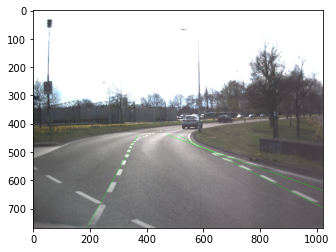

In [16]:
if plotting:
    road_num = '2'
    [lines] = Lane_detection(road_num , plotting)